# support vector machine classifier

features:
- BlockDensity
- OtherPuzAns
- AnswerLength

In [8]:
import pandas as pd
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm #color maps
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [11]:
features = pd.read_csv('nick_df_features.csv',index_col=0)

features.sample(5)

,Date,Weekday,BlockDensity,OtherPuzAns,AnswerLength,WeekdayNum
7449,2014-09-02,Tuesday,16.888889,5286,5.054054,1
9263,2019-08-24,Saturday,15.833333,2116,5.690141,5
4269,2005-11-10,Thursday,15.111111,4525,5.540541,3
3519,2003-09-20,Saturday,12.444444,2931,5.628571,5
3980,2005-01-07,Friday,13.333333,2463,5.735294,4


In [12]:
class_labels = features.groupby(['WeekdayNum','Weekday']).size().reset_index()['Weekday'].tolist()

In [13]:
X = features[['BlockDensity','OtherPuzAns','AnswerLength']].to_numpy()
y = features[['WeekdayNum']].to_numpy()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 617, 
                                                    shuffle=True,
                                                    stratify=y)

## cross-valication for C

In [16]:
kfold = StratifiedKFold(5, shuffle=True, random_state = 440)
Cs = np.linspace(0.1,10,50) 

accs = np.zeros((5,len(Cs)))

for j in range(len(Cs)):
    C = Cs[j]
    
    pipe = Pipeline([('scaler',StandardScaler()),
                    ('pca',PCA(2)),
                    ('svc',LinearSVC(C=C,loss="hinge",max_iter=200000))])
    i = 0
    for train_index,test_index in kfold.split(X_train,y_train):
        X_train_train,X_train_test = X_train[train_index],X_train[test_index]
        y_train_train,y_train_test = y_train[train_index],y_train[test_index]

        pipe_clone = clone(pipe)
        
        pipe_clone.fit(X_train_train,y_train_train.ravel())

        pred = pipe_clone.predict(X_train_test)
        
        accs[i,j] = accuracy_score(y_train_test,pred)

        i = i + 1

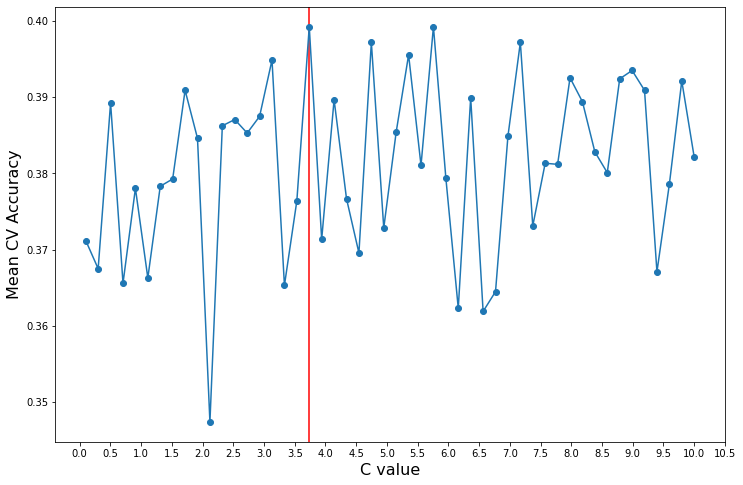

In [27]:
## Plot the mean CV accuracy against C here
best_c = Cs[np.argmax(np.mean(accs, axis=0))]
## Sample Answer
plt.figure(figsize=(12,8))
plt.axvline(x=best_c, color='r')
plt.plot(Cs, np.mean(accs,axis=0), '-o')

plt.xticks(np.arange(0,11,.5))

plt.xlabel("C value", fontsize=16)
plt.ylabel("Mean CV Accuracy", fontsize=16)

plt.show()

In [28]:
print(f"The highest accuraccy is in the model with a max depth of {best_c}.")

The highest accuraccy is in the model with a max depth of 3.736734693877551.


In [31]:
pipe_f = Pipeline([('scaler',StandardScaler()),
                    ('pca',PCA(2)),
                    ('svc',LinearSVC(C=best_c,loss="hinge",max_iter=200000))])

pipe_f.fit(X_test, y_test.ravel())

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('svc',
                 LinearSVC(C=3.736734693877551, loss='hinge',
                           max_iter=200000))])

In [32]:
y_pred = pipe_f.predict(X_test)
f_acc = accuracy_score(y_test,y_pred)
print(f"Overall scores:")
print(f"Accuracy:\t{np.round(f_acc*100,2)}%")

Overall scores:
Accuracy:	36.72%


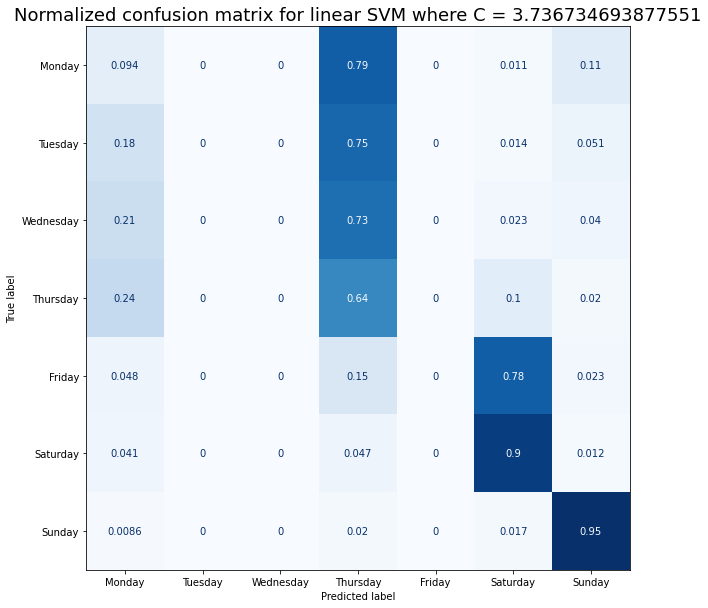

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(pipe_f, X_test, y_test, 
                      display_labels=class_labels,
                      ax=ax, 
                      normalize='true',
                      cmap=cm.get_cmap('Blues'),
                      colorbar=False)
ax.set_title(f"Normalized confusion matrix for linear SVM where C = {best_c}", fontsize=18)
plt.show()